In [1]:
# import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso,LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,roc_curve,confusion_matrix


### Load the dataset

- Load the train data and using all your knowledge try to explore the different statistical properties of the dataset.

In [2]:
# Code starts here
train = pd.read_csv('train.csv')
print(train.head(5))
print(train.shape)
print(train.info())
print(train.describe())

test = pd.read_csv('test.csv')
print(test.shape)
print(test.info())

# Code ends here

     Id  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0  1370  7596-IIWYC  Female              0      No         No      27   
1  5676  9103-CXVOK    Male              0     Yes        Yes       1   
2  5800  7129-CAKJW  Female              0      No         No      17   
3  1645  9490-DFPMD  Female              1      No         No      42   
4   366  9069-LGEUL    Male              0     Yes         No      23   

  PhoneService MultipleLines InternetService  ...     DeviceProtection  \
0          Yes            No              No  ...  No internet service   
1          Yes            No              No  ...  No internet service   
2          Yes           Yes     Fiber optic  ...                  Yes   
3          Yes           Yes     Fiber optic  ...                   No   
4          Yes            No             DSL  ...                   No   

           TechSupport          StreamingTV      StreamingMovies  \
0  No internet service  No internet service  No 

In [3]:

train.drop(['customerID'],1,inplace=True)
test.drop(['customerID'],1,inplace=True)

train["TotalCharges"] = pd.to_numeric(train["TotalCharges"], errors='coerce')
test["TotalCharges"] = pd.to_numeric(test["TotalCharges"], errors='coerce')

# encode target variable as integer
train.loc[train['Churn']=='Yes', 'Churn'] = 1
train.loc[train['Churn']=='No', 'Churn'] = 0

### Visualize the data

- Replace the missing values and modify some column values(as required by you).
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Clean the data, apply some data preprocessing and engineering techniques.

categorical_columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
numerical_columns: ['Id', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


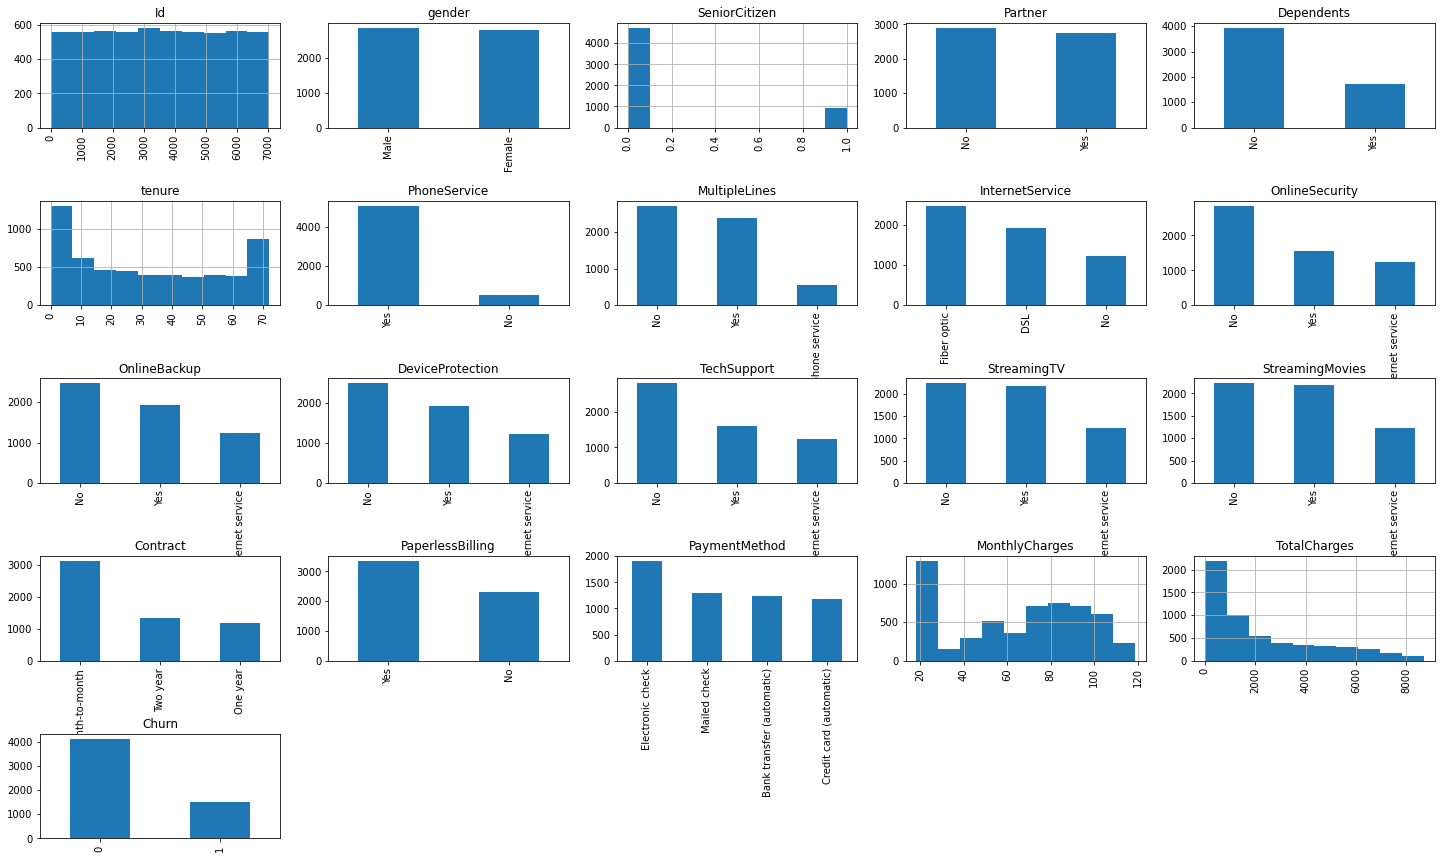

In [4]:
# Code starts here
# choose categorical and continuous features from data

categorical_columns = [c for c in train.columns 
                       if train[c].dtype.name == 'object']
numerical_columns = [c for c in train.columns 
                     if train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(train.shape[1]) / cols)
for i, column in enumerate(train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if train.dtypes[column] == np.object:
        train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


# Code ends here

In [5]:
le = LabelEncoder()

for x in categorical_columns:
    train[x] = le.fit_transform(train[x])
    if x in [c for c in test.columns 
                       if test[c].dtype.name == 'object']:
        test[x] = le.transform(test[x])

In [6]:
# Code Starts here
pd.DataFrame(train).fillna(0,inplace=True)
print(np.where(np.isnan(train)))
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

# Code ends here

(array([], dtype=int64), array([], dtype=int64))


### Model building

- Try to predict the churning of customers using AdaBoost
- Try and implement XGBoost for our customer churn problem and see how it performs in comparision to AdaBoost. Use different techniques you have learned to imporove the performance of the model.
- Try improving upon the `accuracy_score` ([Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

In [7]:
# Code Starts here
dt_clf = DecisionTreeClassifier(max_depth=5 ,random_state=17)
dt_clf.fit(X_train,y_train)
tree_predictions = dt_clf.predict(X_val) 
print("Decision tree accuracy: ",accuracy_score(y_val,tree_predictions))

ada_clf = AdaBoostClassifier(base_estimator=dt_clf,random_state=0,n_estimators=200, 
                             learning_rate=0.5)
ada_clf.fit(X_train,y_train)
ada_boost_predictions = ada_clf.predict(X_val) 
print("AdaBoost accuracy: ",accuracy_score(y_val,ada_boost_predictions))

xgb_clf = XGBClassifier(base_estimator=dt_clf,random_state=18,eval_metric="logloss",n_estimators=200)
xgb_clf.fit(X_train,y_train)
xg_boost_predictions = xgb_clf.predict(X_val) 
print("xgBoost accuracy: ",accuracy_score(y_val,xg_boost_predictions))

# Code ends here

Decision tree accuracy:  0.8018923713778829
AdaBoost accuracy:  0.7563571850975754
[17:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { base_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


xgBoost accuracy:  0.7752808988764045


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [9]:
# Code Starts here
# Storing the id from the test file
pd.DataFrame(test).fillna(0,inplace=True)
id_ = test['Id']

# Predict on the test data
y_pred_test = dt_clf.predict(test)

# Create a sample submission file
final_submission = pd.DataFrame({'Id':id_,'Churn':y_pred_test})

final_submission.loc[final_submission['Churn']==1, 'Churn'] = 'Yes'
final_submission.loc[final_submission['Churn']==0, 'Churn'] = 'No'

# Convert the sample submission file into a csv file
final_submission.to_csv('final_submission.csv',index=False)

# Code ends here